# Blackbox Metamodel Demo of a Regression Task

The `MetamodelRegression` class allows for adding uncertainty prediction to any blackbox model (referred to as `base` model here). The blackbox model may either pre-exist (and be supplied by the user) or be created inside `MetamodelRegression`.

Note: The term "blackbox" refers to the assumption that only the inputs and outputs of such a model can be observed. There is no access to its internal parameters.


#### Import Statements

In [1]:
%matplotlib inline

In [1]:
import matplotlib.pyplot as plt

In [2]:
from uq360.algorithms.blackbox_metamodel import MetamodelRegression

In [3]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import pandas as pd

#### Load Boston Housing Prices Dataset

In [4]:
house_prices_dataset = datasets.load_boston()
house_prices_df = pd.DataFrame(house_prices_dataset['data'])
house_prices_df.columns = house_prices_dataset['feature_names']

# Let us pick the number of rooms as the single input feature for our model
X = house_prices_df['RM']
y = house_prices_dataset['target']

In [5]:
X = X.values.reshape((-1,1))
print(X.shape)
print(y.shape)

(506, 1)
(506,)


#### Train test split of the dataset

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Text(0.5, 1.0, 'Training data')

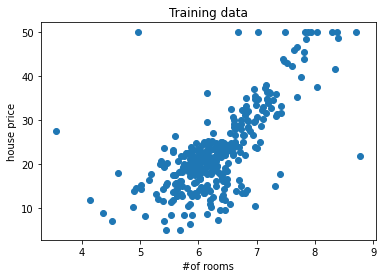

In [7]:
plt.scatter(X_train, y_train)
plt.xlabel('#of rooms')
plt.ylabel('house price')
plt.title('Training data')

In [14]:
def display_results(X_test, y_test, y_mean, y_lower, y_upper):
    pred_dict = {'rooms': X_test[:,0],
                 'y': y_test,
                 'y_mean': y_mean,
                 'y_upper': y_upper,
                 'y_lower': y_lower
                }

    pred_df = pd.DataFrame(data=pred_dict)

    pred_df_sorted = pred_df.sort_values(by='rooms')

    plt.plot(pred_df_sorted['rooms'], pred_df_sorted['y'], 'o', label='Observed')
    plt.plot(pred_df_sorted['rooms'], pred_df_sorted['y_mean'], '-', lw=2, label='Predicted')
    plt.plot(pred_df_sorted['rooms'], pred_df_sorted['y_upper'], 'r--', lw=2, label='Upper Bound')
    plt.plot(pred_df_sorted['rooms'], pred_df_sorted['y_lower'], 'r--', lw=2, label='Lower Bound')
    plt.legend()
    plt.xlabel('#of rooms')
    plt.ylabel('house price')
    plt.title('Test data')

### Train a Blackbox Regression Uncertainty Model

In a first example, the `MetamodelRegression` class' built-in instantiation mechanism for both the base and the meta model are used. The model type is specified "by name" (`gbr`) here.  

In [15]:
base_config = {
    "loss": "ls",
    "n_estimators":50,
    "max_depth":3,
    "learning_rate":0.1,
    "min_samples_leaf":9,
    "min_samples_split":9
}
meta_config = {
    "loss": "quantile",
    "alpha":0.95,
    "n_estimators":50,
    "max_depth":3,
    "learning_rate":0.1,
    "min_samples_leaf":9,
    "min_samples_split":9
}

uq_model = MetamodelRegression(base_model='gbr', meta_model='gbr', base_config=base_config, meta_config=meta_config)

In [16]:
# this will fit both the base and the meta model 
_ = uq_model.fit(X_train, y_train)

In [17]:
X_train.shape

(354, 1)

In [18]:
y_hat, y_hat_lb, y_hat_ub = uq_model.predict(X_test)

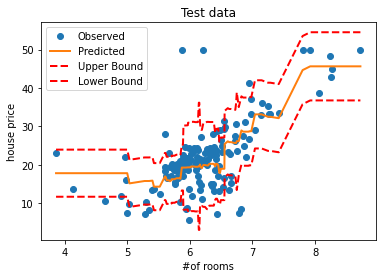

In [19]:
display_results(X_test, y_test, y_mean=y_hat, y_lower=y_hat_lb, y_upper=y_hat_ub)

### Use Linear Regression as Metamodel

Next, an example of instantiation by providing a class declaration for each of the (base, meta) models.

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
meta_config = {'fit_intercept': True, 'copy_X': True}

In [21]:
# Instantiation from class interface
uq_model = MetamodelRegression(base_model=GradientBoostingRegressor, meta_model=LinearRegression,                
              base_config=base_config, meta_config=meta_config)

In [22]:
_ = uq_model.fit(X_train, y_train)

In [23]:
y_hat, y_hat_lb, y_hat_ub = uq_model.predict(X_test)

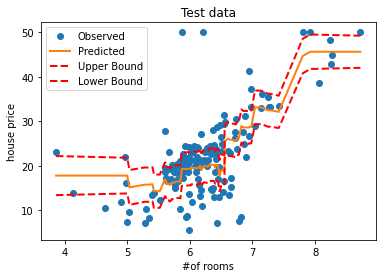

In [24]:
display_results(X_test, y_test, y_mean=y_hat, y_lower=y_hat_lb, y_upper=y_hat_ub)

Note that the bounds above are 0.5-quantile and need to be recalibrated to a desired operating point.
(you may use the Uncertainty Characteristics Curve tool to achieve that)

## If the base model has been trained externally

In practice a base model may pre-exist and have been trained already. Moreover, the training of a base model may be expensive and the full training data may not be available, which makes an internal (re-)training of ` MetamodelRegression` via `fit()` undesirable or even impossible. 
The API provides for this situation: First, we instantiate the ` MetamodelRegression` using the existing base model instance. Then use the option `base_is_prefitted=True`, and an optional `meta_train_data` specification, when calling the `fit()` method.

In [25]:
# split the training partition to provide base and meta training sets
X_train_base, X_train_meta, y_train_base, y_train_meta = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [26]:
# Simulate a pre-existing, pre-trained base model 
base_mdl = GradientBoostingRegressor(**base_config)
_ = base_mdl.fit(X_train_base, y_train_base)

In [27]:
# Create a Blackbox instance using the above and an instance of an LR model as meta model 
meta_mdl = LinearRegression(**meta_config)
uq_model = MetamodelRegression(base_model=base_mdl, meta_model=meta_mdl, 
                             base_config=None, meta_config=meta_config)

In [28]:
# now fit the meta model only
_ = uq_model.fit(X=None, y=None, base_is_prefitted=True, meta_train_data=(X_train_meta, y_train_meta))

In [29]:
y_hat, y_hat_lb, y_hat_ub = uq_model.predict(X_test)

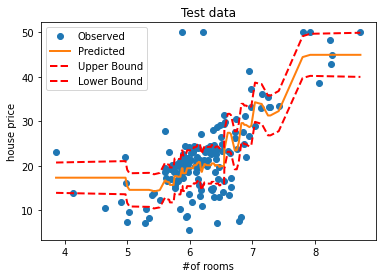

In [30]:
display_results(X_test, y_test, y_mean=y_hat, y_lower=y_hat_lb, y_upper=y_hat_ub)